In [2]:
!pip install yfinance

  Using cached yfinance-0.2.40-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached lxml-5.2.2-cp311-cp311-manylinux_2_28_aarch64.whl.metadata (3.4 kB)
  Using cached frozendict-2.4.4-py311-none-any.whl.metadata (23 kB)
  Using cached peewee-3.17.5-cp311-cp311-linux_aarch64.whl
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
Using cached yfinance-0.2.40-py2.py3-none-any.whl (73 kB)
Using cached frozendict-2.4.4-py311-none-any.whl (16 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached lxml-5.2.2-cp311-cp311-manylinux_2_28_aarch64.whl (4.8 MB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

In [4]:
# Load the zip file
df = pd.read_csv('snp_beta_macd_signal_rsi.zip', compression='zip')
df.head()

,Stock,2014-05-01 00:00:00,2014-05-02 00:00:00,2014-05-05 00:00:00,2014-05-06 00:00:00,2014-05-07 00:00:00,2014-05-08 00:00:00,2014-05-09 00:00:00,2014-05-12 00:00:00,2014-05-13 00:00:00,...,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00,Industry,Beta,MACD,Signal,RSI
0,A,35.818909,35.864948,36.384441,36.174015,36.187160,36.364704,36.423893,37.094631,37.370804,...,137.490005,136.369995,137.740005,139.589996,137.039993,Diagnostics & Research,1.126,-1.536634,-1.509291,45.444335
1,AAL,34.306366,34.400639,34.504337,34.570320,35.088844,36.059853,36.069294,37.134579,37.059177,...,13.920000,14.130000,13.880000,13.980000,13.510000,Airlines,1.580,-0.129848,-0.153215,39.044930
2,AAPL,18.581390,18.615952,18.879210,18.673439,18.608089,18.574923,18.497526,18.727819,18.757200,...,168.791061,169.659882,169.070679,173.264984,170.099289,Consumer Electronics,1.264,-0.861375,-1.433049,52.048345
3,ABBV,34.194000,33.909100,34.028362,33.730228,34.975811,34.551777,34.624657,34.697540,34.584908,...,167.800003,167.289993,159.619995,161.520004,162.639999,Drug Manufacturers - General,0.593,-2.645659,-2.440588,39.560258
4,ABNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,162.839996,163.009995,164.229996,162.250000,158.570007,Travel Services,1.246,0.133508,0.029556,43.219668


#### Delete additional rows added for RSI, MACD values

In [5]:
# Delete rows with Stock name containin '_'
df = df[~df['Stock'].str.contains('_')]
df.shape

(503, 2523)

#### Get Additional Data like PE, Earnings_Growth, Volatility, etc. from Yahoo Finance

In [6]:
# Function to calculate historical volatility based on annualized standard deviation of returns
# returns are calculated as percentage change in closing prices
def calculate_volatility(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period='max') # Max period available
    returns = hist['Close'].pct_change().dropna() # percentage change in closing prices
    if len(returns) == 0:
        return None
    volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility
    return volatility

In [7]:
# Function to fetch other financial data for a given ticker
def fetch_financial_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        volatility = calculate_volatility(ticker) # Calculate volatility for last 1y
        
        return {
            'PE_Ratio': info.get('trailingPE', None),
            'EPS': info.get('trailingEps', None),
            'Earnings_Growth': info.get('earningsQuarterlyGrowth', None),
            'Volatility': volatility,
            'Market_Cap': info.get('marketCap', None),
            'Debt_to_Equity': info.get('debtToEquity', None),
            'Dividend_Yield': info.get('dividendYield', None)
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return {
            'PE_Ratio': None,
            'EPS': None,
            'Earnings_Growth': None,
            'Volatility': None,
            'Market_Cap': None,
            'Debt_to_Equity': None,
            'Dividend_Yield': None
        }

In [8]:
# Apply the function to each ticker in the DataFrame
financial_data = df['Stock'].apply(fetch_financial_data)
financial_df = pd.DataFrame(financial_data.tolist())

# Merge the financial data with the original DataFrame
df = pd.concat([df, financial_df], axis=1)

# Display the updated DataFrame
print(df)

/tmp/ipykernel_12662/2492635859.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist['Close'].pct_change().dropna() # percentage change in closing prices


    Stock  2014-05-01 00:00:00  2014-05-02 00:00:00  2014-05-05 00:00:00  \
0       A            35.818909            35.864948            36.384441   
1     AAL            34.306366            34.400639            34.504337   
2    AAPL            18.581390            18.615952            18.879210   
3    ABBV            34.194000            33.909100            34.028362   
4    ABNB                  NaN                  NaN                  NaN   
..    ...                  ...                  ...                  ...   
498   XYL            32.479702            32.391838            32.312733   
499   YUM            45.543854            45.513985            45.573730   
500   ZBH            87.445427            87.992554            88.817650   
501  ZBRA            70.529999            71.919998            72.199997   
502   ZTS            28.207462            28.514559            28.412199   

     2014-05-06 00:00:00  2014-05-07 00:00:00  2014-05-08 00:00:00  \
0              36

In [9]:
df.head()

,Stock,2014-05-01 00:00:00,2014-05-02 00:00:00,2014-05-05 00:00:00,2014-05-06 00:00:00,2014-05-07 00:00:00,2014-05-08 00:00:00,2014-05-09 00:00:00,2014-05-12 00:00:00,2014-05-13 00:00:00,...,MACD,Signal,RSI,PE_Ratio,EPS,Earnings_Growth,Volatility,Market_Cap,Debt_to_Equity,Dividend_Yield
0,A,35.818909,35.864948,36.384441,36.174015,36.187160,36.364704,36.423893,37.094631,37.370804,...,-1.536634,-1.509291,45.444335,31.511848,4.22,0.020,0.415737,38798376960,43.869,0.0071
1,AAL,34.306366,34.400639,34.504337,34.570320,35.088844,36.059853,36.069294,37.134579,37.059177,...,-0.129848,-0.153215,39.044930,16.197184,0.71,NaN,0.658142,7545034752,NaN,NaN
2,AAPL,18.581390,18.615952,18.879210,18.673439,18.608089,18.574923,18.497526,18.727819,18.757200,...,-0.861375,-1.433049,52.048345,30.572980,6.44,-0.022,0.443116,3019131060224,140.968,0.0051
3,ABBV,34.194000,33.909100,34.028362,33.730228,34.975811,34.551777,34.624657,34.697540,34.584908,...,-2.645659,-2.440588,39.560258,50.573135,3.35,4.728,0.263262,299173675008,924.059,0.0366
4,ABNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.133508,0.029556,43.219668,19.659517,7.46,1.256,0.508553,93106225152,29.002,NaN


#### Rearrange the columns

In [10]:
df.columns

Index(['Stock', '2014-05-01 00:00:00', '2014-05-02 00:00:00',
       '2014-05-05 00:00:00', '2014-05-06 00:00:00', '2014-05-07 00:00:00',
       '2014-05-08 00:00:00', '2014-05-09 00:00:00', '2014-05-12 00:00:00',
       '2014-05-13 00:00:00',
       ...
       'MACD', 'Signal', 'RSI', 'PE_Ratio', 'EPS', 'Earnings_Growth',
       'Volatility', 'Market_Cap', 'Debt_to_Equity', 'Dividend_Yield'],
      dtype='object', length=2530)

In [11]:
# Move newly added columns to the front, after beta column
# First move all columns at the end to the front, after stock column
cols = df.columns.tolist()
cols = cols[:1] + cols[-12:] + cols[1:-12]
print(cols)
print(len(cols))
# Now move columns MACD, Signal and RSI after ''Dividend_Yield'
cols = ['Stock', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap', 'Dividend_Yield'] + cols[13:]
print(cols)
print(len(cols))
df = df[cols]
df.head()



['Stock', 'Industry', 'Beta', 'MACD', 'Signal', 'RSI', 'PE_Ratio', 'EPS', 'Earnings_Growth', 'Volatility', 'Market_Cap', 'Debt_to_Equity', 'Dividend_Yield', '2014-05-01 00:00:00', '2014-05-02 00:00:00', '2014-05-05 00:00:00', '2014-05-06 00:00:00', '2014-05-07 00:00:00', '2014-05-08 00:00:00', '2014-05-09 00:00:00', '2014-05-12 00:00:00', '2014-05-13 00:00:00', '2014-05-14 00:00:00', '2014-05-15 00:00:00', '2014-05-16 00:00:00', '2014-05-19 00:00:00', '2014-05-20 00:00:00', '2014-05-21 00:00:00', '2014-05-22 00:00:00', '2014-05-23 00:00:00', '2014-05-27 00:00:00', '2014-05-28 00:00:00', '2014-05-29 00:00:00', '2014-05-30 00:00:00', '2014-06-02 00:00:00', '2014-06-03 00:00:00', '2014-06-04 00:00:00', '2014-06-05 00:00:00', '2014-06-06 00:00:00', '2014-06-09 00:00:00', '2014-06-10 00:00:00', '2014-06-11 00:00:00', '2014-06-12 00:00:00', '2014-06-13 00:00:00', '2014-06-16 00:00:00', '2014-06-17 00:00:00', '2014-06-18 00:00:00', '2014-06-19 00:00:00', '2014-06-20 00:00:00', '2014-06-23 00:

,Stock,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,Diagnostics & Research,1.126,0.415737,43.869,31.511848,0.020,-1.536634,-1.509291,45.444335,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,Airlines,1.580,0.658142,NaN,16.197184,NaN,-0.129848,-0.153215,39.044930,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,Consumer Electronics,1.264,0.443116,140.968,30.572980,-0.022,-0.861375,-1.433049,52.048345,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,Drug Manufacturers - General,0.593,0.263262,924.059,50.573135,4.728,-2.645659,-2.440588,39.560258,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Travel Services,1.246,0.508553,29.002,19.659517,1.256,0.133508,0.029556,43.219668,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


#### NaN values

In [12]:
# Print NaN values in each of first 13 columns one by one
for col in df.columns[:13]:
    print(f"{col}: {df[col].isna().sum()}")

Stock: 0
Industry: 0
Beta: 10
Volatility: 0
Debt_to_Equity: 55
PE_Ratio: 32
Earnings_Growth: 60
MACD: 0
Signal: 0
RSI: 0
EPS: 3
Market_Cap: 0
Dividend_Yield: 98


In [13]:
# Fill NaNs with mean value of each column
df['Beta'].fillna(df['Beta'].mean(), inplace=True)
df['Debt_to_Equity'].fillna(df['Debt_to_Equity'].mean(), inplace=True)
df['PE_Ratio'].fillna(df['PE_Ratio'].mean(), inplace=True)
df['Earnings_Growth'].fillna(df['Earnings_Growth'].mean(), inplace=True)
df['EPS'].fillna(df['EPS'].mean(), inplace=True)
df['Dividend_Yield'].fillna(df['Dividend_Yield'].mean(), inplace=True)

In [14]:
# Print NaN values in each of first 13 columns one by one
for col in df.columns[:13]:
    print(f"{col}: {df[col].isna().sum()}")

Stock: 0
Industry: 0
Beta: 0
Volatility: 0
Debt_to_Equity: 0
PE_Ratio: 0
Earnings_Growth: 0
MACD: 0
Signal: 0
RSI: 0
EPS: 0
Market_Cap: 0
Dividend_Yield: 0


#### Formatting

1. Market_Cap to Market_Cap (Millions)

In [15]:
# Convert Market cap to millions
df['Market_Cap'] = df['Market_Cap'] / 1000000
# Change the column name from 'Market_Cap' to 'Market_Cap_Millions'
df.rename(columns={'Market_Cap': 'Market_Cap (Millions)'}, inplace=True)
df.head()

,Stock,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,Diagnostics & Research,1.126,0.415737,43.869000,31.511848,0.020000,-1.536634,-1.509291,45.444335,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,39.044930,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,52.048345,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,Drug Manufacturers - General,0.593,0.263262,924.059000,50.573135,4.728000,-2.645659,-2.440588,39.560258,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,43.219668,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


In [16]:
df.describe()

,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,EPS,Market_Cap (Millions),...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02,...,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,1.064682,0.377812,172.635933,32.080435,0.468858,-1.370380,-1.293505,45.167481,8.213420,9.908477e+04,...,208.143588,207.671791,206.637771,208.333217,210.680784,210.621875,210.396446,211.089366,212.037288,208.840185
std,0.423367,0.207359,467.385210,38.495780,2.314804,6.202502,5.013966,15.877901,24.012546,2.986898e+05,...,445.307214,446.138067,443.248147,448.513660,452.219466,451.135352,450.340644,449.543691,447.171268,440.569970
min,-0.007000,0.193885,0.405000,3.237935,-0.998000,-44.958198,-33.180313,12.266981,-22.010000,6.370805e+03,...,8.230000,8.310000,8.400000,8.470000,8.440000,8.380000,8.290000,8.110000,8.150000,7.360000
25%,0.777500,0.290532,46.282500,16.673129,-0.152500,-1.950257,-1.889541,33.248331,2.375000,1.784651e+04,...,63.244999,63.195501,62.255001,62.814131,63.903008,64.610001,64.181244,64.770000,65.305000,64.705002
50%,1.064682,0.345220,85.763000,26.149511,0.096000,-0.388046,-0.336862,44.332262,5.030000,3.393886e+04,...,116.449997,116.687469,117.430000,118.586693,119.489998,119.919998,118.440002,117.209999,119.150002,117.317093
75%,1.296000,0.428504,172.635933,34.199268,0.468858,0.598923,0.411674,56.744255,8.935000,7.176194e+04,...,216.294998,214.065002,215.659996,217.895004,219.470001,217.889999,218.474998,219.505447,220.029999,217.620003
max,3.293000,4.266585,7850.252000,711.105830,39.533000,81.816700,60.101981,91.452427,479.850000,3.150184e+06,...,7669.939941,7702.259766,7685.000000,7806.790039,7835.109863,7798.279785,7725.000000,7647.040039,7540.000000,7438.850098


## Risk Level Calculation

#### Classify Stocks into 3 categories based on the following criteria:
1. Low Risk: Volatility < 0.2, Beta < 0.9, Debt to Equity < 0.5, Earnings Growth >= 15% and PE < 15

2. Medium Risk: Volatility < 0.35, Beta < 1.2, Debt to Equity < 1, Earnings Growth < 15% and PE < 25

3. High Risk: Rest of the stocks



#### Criteria 1

In [17]:
# Function to classify stocks into risk levels based on defined criteria
def classify_risk(row):
    if (row['Volatility'] < 0.2 and
        row['Beta'] < 0.9 and
        row['Debt_to_Equity'] < 50 and
        row['Earnings_Growth'] >= 0.15 and
        row['PE_Ratio'] < 15):
        return 'Low'
    elif (0.2 <= row['Volatility'] < 0.35 and
          0.9 <= row['Beta'] < 1.2 and
          50 <= row['Debt_to_Equity'] < 200 and
          0.05 <= row['Earnings_Growth'] < 0.15 and
          15 <= row['PE_Ratio'] < 25):
        return 'Medium'
    else:
        return 'High'

In [18]:
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

,Stock,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,...,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00,Risk_Level
0,A,Diagnostics & Research,1.126,0.415737,43.869000,31.511848,0.020000,-1.536634,-1.509291,45.444335,...,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993,High
1,AAL,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,39.044930,...,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000,High
2,AAPL,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,52.048345,...,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289,High
3,ABBV,Drug Manufacturers - General,0.593,0.263262,924.059000,50.573135,4.728000,-2.645659,-2.440588,39.560258,...,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999,High
4,ABNB,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,43.219668,...,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007,High


In [19]:
# Move the 'Risk_Level' column after the 'Stock' column
cols = df.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
df = df[cols]
df.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,High,Diagnostics & Research,1.126,0.415737,43.869000,31.511848,0.020000,-1.536634,-1.509291,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,High,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,High,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,High,Drug Manufacturers - General,0.593,0.263262,924.059000,50.573135,4.728000,-2.645659,-2.440588,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,High,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


In [20]:
# Plot the distribution of risk levels
import seaborn as sns
import matplotlib.pyplot as plt

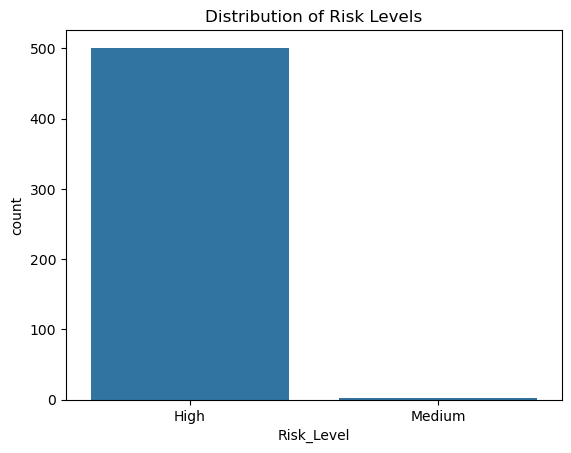

In [21]:
sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

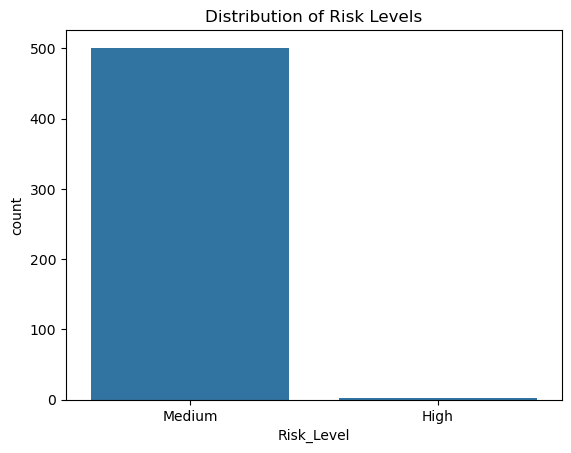

In [22]:
# Function to classify stocks into risk levels based on defined criteria
def classify_risk(row):
    if (row['Volatility'] < 0.2 and
        row['Beta'] < 0.9 and
        row['Debt_to_Equity'] < 50 and
        row['Earnings_Growth'] >= 0.15 and
        row['PE_Ratio'] < 15):
        return 'Low'
    elif (0.35 < row['Volatility'] and
          1.2 < row['Beta'] and
          row['Debt_to_Equity'] >= 200 and
          row['Earnings_Growth'] < 0.05 and
          row['PE_Ratio'] >= 25):
        return 'High'
    else:
        return 'Medium'

# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

### Criteria 2

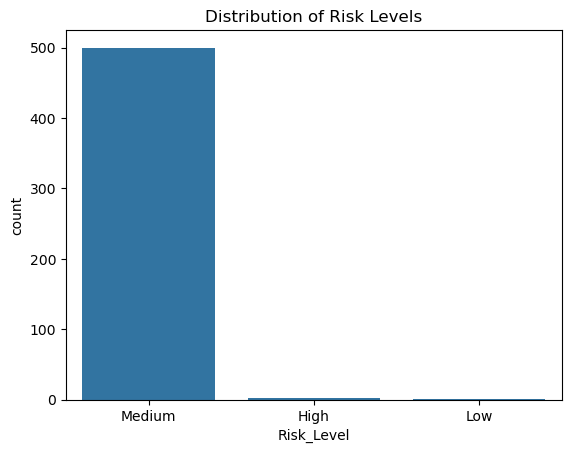

In [23]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 0.9 and row['Debt_to_Equity'] <= 50 and row['Earnings_Growth'] >= 0.3 and 
        row['PE_Ratio'] <= 25 and row['Volatility'] <= 0.25):
        return 'Low'
    elif (row['Beta'] > 1.2 and row['Debt_to_Equity'] > 150 and row['Earnings_Growth'] < 0.1 and row['PE_Ratio'] > 35 and row['Volatility'] > 0.35):
        return 'High'
    else:
        return 'Medium'  # Set "Medium Risk" as the default condition

# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()


#### Criteria 3
Using only 3 features for now: Volatility, Beta, Debt to Equity

In [24]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 0.9 and row['Debt_to_Equity'] <= 50 and row['Volatility'] <= 0.25):
        return 'Low'
    elif (row['Beta'] > 1.2 and row['Debt_to_Equity'] > 150 and row['Volatility'] > 0.35):
        return 'High'
    else:
        return 'Medium'

In [25]:
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,Medium,Diagnostics & Research,1.126,0.415737,43.869000,31.511848,0.020000,-1.536634,-1.509291,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,High,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,Medium,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,Medium,Drug Manufacturers - General,0.593,0.263262,924.059000,50.573135,4.728000,-2.645659,-2.440588,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Medium,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


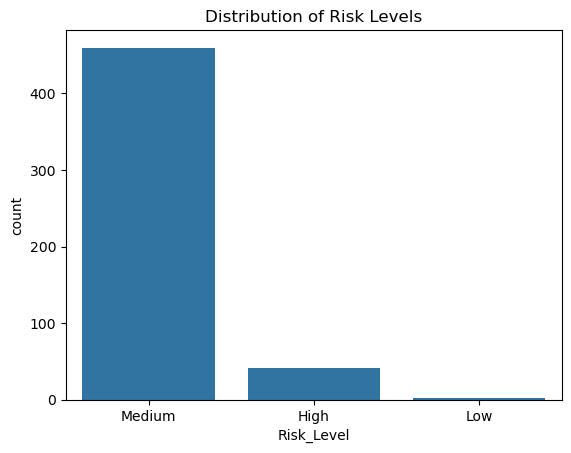

In [26]:
sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

#### Criteria 4 (Based on Brad's previous suggestion)

1. Aggressive Growth - High risk, high reward. Invest in high-growth companies with high volatility. Beta > 1.5, P/E > 30, EPS Growth > 20%.

2. Growth - Invest in companies with strong growth potential. Beta > 1, P/E > 20, EPS Growth > 15%.

3. Balanced - Invest in a mix of growth and value stocks. Beta > 0.8, P/E > 15, EPS Growth > 10%.

4. Conservative - Invest in stable companies with low volatility. Beta < 0.5, P/E < 10, EPS Growth < 5%.

5. Defensive - Invest in defensive stocks that are less affected by economic downturns. Beta < 0.5, P/E < 15, EPS Growth < 10%.

In [27]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] < 0.5 and row['Earnings_Growth'] < 0.05 and row['PE_Ratio'] < 10 ):
        return 'Low'
    elif (row['Beta'] > 1.5 or row['PE_Ratio'] > 30 or row['Earnings_Growth'] < 0.2):
        return 'High'
    else:
        return 'Medium'

In [28]:
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
df.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,A,High,Diagnostics & Research,1.126,0.415737,43.869000,31.511848,0.020000,-1.536634,-1.509291,...,134.550003,132.440002,132.729996,133.910004,139.199997,137.490005,136.369995,137.740005,139.589996,137.039993
1,AAL,High,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,...,13.890000,14.020000,14.110000,14.530000,14.230000,13.920000,14.130000,13.880000,13.980000,13.510000
2,AAPL,High,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,...,167.772446,166.813736,164.776505,165.615356,166.673920,168.791061,169.659882,169.070679,173.264984,170.099289
3,ABBV,High,Drug Manufacturers - General,0.593,0.263262,924.059000,50.573135,4.728000,-2.645659,-2.440588,...,164.250000,164.660004,166.410004,167.889999,169.539993,167.800003,167.289993,159.619995,161.520004,162.639999
4,ABNB,Medium,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,...,158.369995,160.100006,155.009995,156.610001,160.949997,162.839996,163.009995,164.229996,162.250000,158.570007


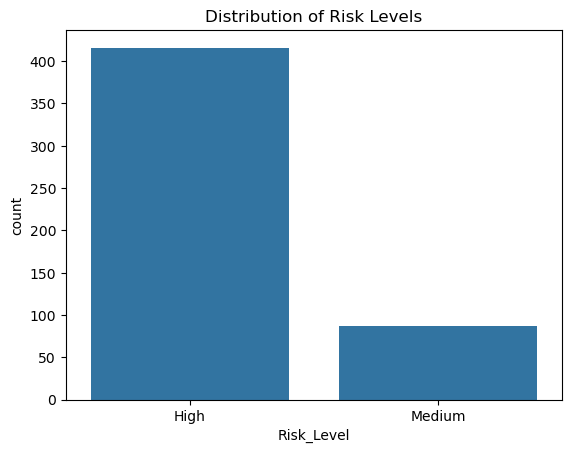

In [29]:
sns.countplot(data=df, x='Risk_Level')
plt.title('Distribution of Risk Levels')
plt.show()

#### Criteria 5

  Stock Risk_Level                      Industry   Beta  Volatility  \
0     A  High Risk        Diagnostics & Research  1.126    0.415737   
1   AAL  High Risk                      Airlines  1.580    0.658142   
2  AAPL  High Risk          Consumer Electronics  1.264    0.443116   
3  ABBV  High Risk  Drug Manufacturers - General  0.593    0.263262   
4  ABNB  High Risk               Travel Services  1.246    0.508553   

   Debt_to_Equity   PE_Ratio  Earnings_Growth      MACD    Signal  ...  \
0       43.869000  31.511848         0.020000 -1.536634 -1.509291  ...   
1      172.635933  16.197184         0.468858 -0.129848 -0.153215  ...   
2      140.968000  30.572980        -0.022000 -0.861375 -1.433049  ...   
3      924.059000  50.573135         4.728000 -2.645659 -2.440588  ...   
4       29.002000  19.659517         1.256000  0.133508  0.029556  ...   

   2024-04-17 00:00:00  2024-04-18 00:00:00  2024-04-19 00:00:00  \
0           134.550003           132.440002           132.72

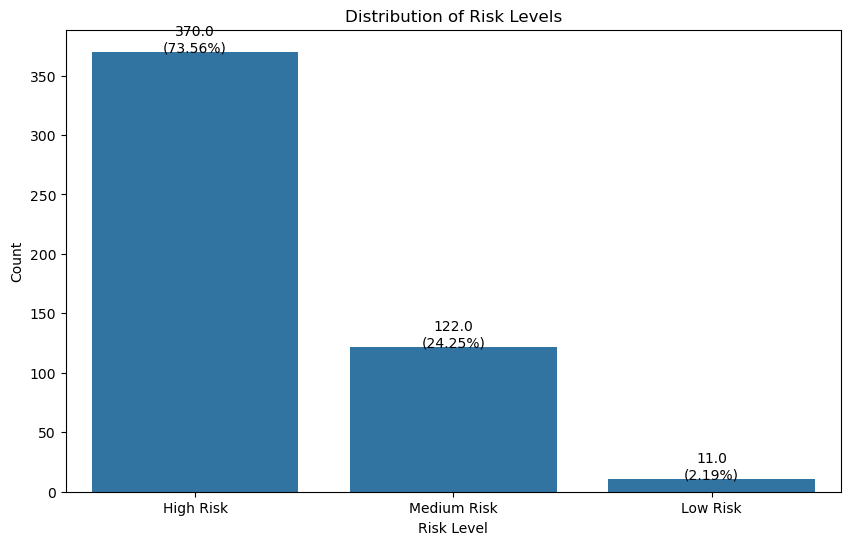

In [30]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 1.0 and row['Debt_to_Equity'] <= 100 and row['Earnings_Growth'] >= 0.2 and 
        row['PE_Ratio'] <= 30 and row['Volatility'] <= 0.3):
        return 'Low Risk'
    elif (row['Beta'] > 1.3 or row['Debt_to_Equity'] > 200 or row['Earnings_Growth'] < 0.0 or 
          row['PE_Ratio'] > 40 or row['Volatility'] > 0.4):
        return 'High Risk'
    else:
        return 'Medium Risk'
    
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)
print(df.head())

# sns.countplot(data=df, x='Risk_Level')
# plt.title('Distribution of Risk Levels')
# plt.show()

# Plot the count of stocks for each risk level
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Risk_Level', order=df['Risk_Level'].value_counts().index)
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')

# Add counts and percentages above bars
for p in ax.patches:
    count = p.get_height()
    total = len(df)
    percentage = (count / total) * 100
    ax.annotate(f'{count}\n({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=10)

plt.show()

#### Criteria 6
1. Low Risk: Volatility <= 0.3, Beta <= 0.8
2. High Risk: Volatility > 0.4, Beta > 1.2
3. Medium Risk: Rest of the stocks

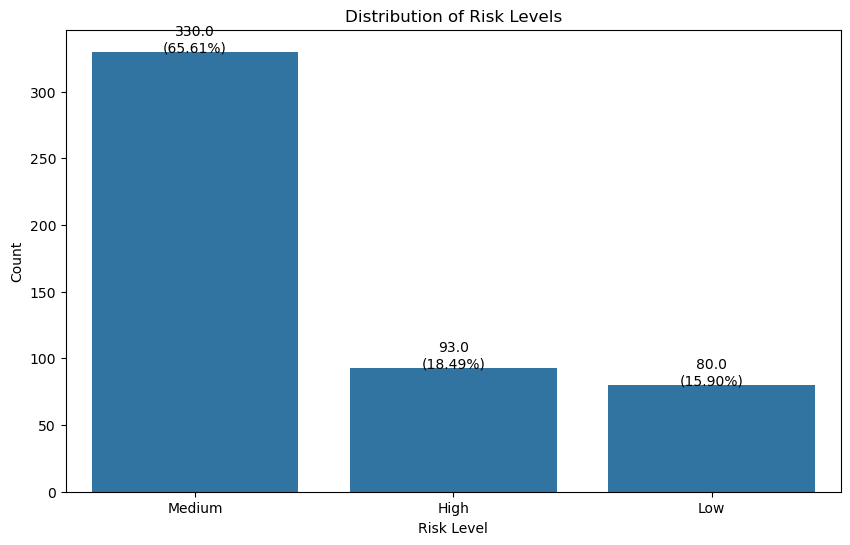

In [31]:
# Define risk classification function
def classify_risk(row):
    if (row['Beta'] <= 0.8 and row['Volatility'] <= 0.3):
        return 'Low'
    elif (row['Beta'] > 1.2 and row['Volatility'] > 0.4):
        return 'High'
    else:
        return 'Medium'
    
# Apply the classification function to each row
df['Risk_Level'] = df.apply(classify_risk, axis=1)

# sns.countplot(data=df, x='Risk_Level')
# plt.title('Distribution of Risk Levels')
# plt.show()

# Plot the count of stocks for each risk level
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Risk_Level', order=df['Risk_Level'].value_counts().index)
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')

# Add counts and percentages above bars
for p in ax.patches:
    count = p.get_height()
    total = len(df)
    percentage = (count / total) * 100
    ax.annotate(f'{count}\n({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=10)

plt.show()

In [32]:
# Save the updated DataFrame to a new CSV file
df.to_csv('snp_portfolio_final.csv', index=False)

## Recency Checks

### 1. Time-Series Check (RSI and MACD)

In [33]:
def filter_stocks(df, risk_level, rsi_max=30, macd_min=0):
    """
    Filters stocks based on risk level, RSI, and MACD values.
    
    Args:
    df (pd.DataFrame): DataFrame containing stock data.
    risk_level (str): Desired risk level (e.g., 'Low Risk', 'Medium Risk', 'High Risk').
    rsi_max (float): Maximum RSI value for considering a stock.
    macd_min (float): Minimum MACD value for considering a stock.
    
    Returns:
    pd.DataFrame: Filtered DataFrame with stocks that meet the criteria.
    """
    filtered_df = df[df['Risk_Level'] == risk_level]
    # filtered_df = filtered_df[((filtered_df['RSI'] < rsi_max) | 
    #                            (filtered_df['RSI'].between(30, 70))) & 
    #                           (filtered_df['MACD'] > macd_min) & 
    #                           (filtered_df['MACD'] > filtered_df['Signal'])]
    # filtered_df = filtered_df[(filtered_df['RSI'] < 70) & 
    #                           (filtered_df['MACD'] > macd_min)]
    filtered_df = filtered_df[(filtered_df['RSI'] < 70) & 
                              (filtered_df['MACD'] > filtered_df['Signal'])]
    return filtered_df

In [34]:
## Test the function
# Low Risk
filtered_low_risk_stocks = filter_stocks(df, 'Low')
print(df['Risk_Level'].value_counts())
print(filtered_low_risk_stocks['Risk_Level'].value_counts())
print(filtered_low_risk_stocks.describe())


Risk_Level
Medium    330
High       93
Low        80
Name: count, dtype: int64
Risk_Level
Low    50
Name: count, dtype: int64
            Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  50.000000   50.000000       50.000000   50.000000        50.000000   
mean    0.537420    0.245425      174.257076   27.330018         0.203006   
std     0.164402    0.028815      204.437785   25.090266         0.536606   
min     0.140000    0.193885       24.846000    5.649498        -0.758000   
25%     0.408000    0.221452       93.326000   16.534129        -0.090500   
50%     0.555500    0.245646      141.425500   19.801796         0.092000   
75%     0.671000    0.267511      178.586750   26.122066         0.385000   
max     0.793000    0.299044     1184.314000  145.188890         2.901000   

            MACD     Signal        RSI       EPS  Market_Cap (Millions)  ...  \
count  50.000000  50.000000  50.000000  50.00000              50.000000  ...   
mean    0.033856  -0

In [35]:
# Medium Risk
filtered_medium_risk_stocks = filter_stocks(df, 'Medium')
print(filtered_medium_risk_stocks['Risk_Level'].value_counts())
print(filtered_medium_risk_stocks.describe())

Risk_Level
Medium    137
Name: count, dtype: int64
             Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  137.000000  137.000000      137.000000  137.000000       137.000000   
mean     1.004293    0.353840      211.997553   30.368626         0.534546   
std      0.273653    0.085465      713.708763   18.495191         3.458097   
min      0.387000    0.220201        0.693000    5.582418        -0.998000   
25%      0.822000    0.305372       53.982000   17.728370        -0.150000   
50%      1.007000    0.336163       90.986000   28.409006         0.128000   
75%      1.144000    0.378157      172.635933   36.081300         0.468858   
max      1.909000    0.786764     7850.252000  129.500000        39.533000   

             MACD      Signal         RSI         EPS  Market_Cap (Millions)  \
count  137.000000  137.000000  137.000000  137.000000           1.370000e+02   
mean    -0.479423   -0.980375   51.087930    7.006984           1.029288e+05   
std   

In [36]:
# High Risk
filtered_high_risk_stocks = filter_stocks(df, 'High')
print(filtered_high_risk_stocks['Risk_Level'].value_counts())
print(filtered_high_risk_stocks.describe())

Risk_Level
High    39
Name: count, dtype: int64
            Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  39.000000   39.000000       39.000000   39.000000        39.000000   
mean    1.608128    0.508933      230.270993   54.177121         0.276747   
std     0.383939    0.086246      630.173145  116.258028         1.075909   
min     1.203000    0.401898        0.405000    6.466666        -0.744000   
25%     1.317000    0.445118       31.114000   15.562697        -0.185000   
50%     1.508000    0.481451       85.664000   26.681034         0.202000   
75%     1.772500    0.570257      172.635933   40.398487         0.468858   
max     2.597000    0.737160     3984.371000  711.105830         6.284000   

            MACD     Signal        RSI        EPS  Market_Cap (Millions)  ...  \
count  39.000000  39.000000  39.000000  39.000000           3.900000e+01  ...   
mean   -1.754103  -2.713835  52.090956   5.412308           2.080171e+05  ...   
std     5.02326

In [37]:
# Combine the filtered DataFrames
filtered_stocks = pd.concat([filtered_low_risk_stocks, filtered_medium_risk_stocks, filtered_high_risk_stocks])
print(filtered_stocks['Risk_Level'].value_counts())
print(filtered_stocks.describe())

Risk_Level
Medium    137
Low        50
High       39
Name: count, dtype: int64
             Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth  \
count  226.000000  226.000000      226.000000  226.000000       226.000000   
mean     1.005204    0.356618      206.801271   33.804913         0.416709   
std      0.433225    0.112364      620.008178   52.105603         2.740149   
min      0.140000    0.193885        0.405000    5.582418        -0.998000   
25%      0.706000    0.275174       58.142500   17.124972        -0.139500   
50%      0.974500    0.330731      110.567500   25.760807         0.128500   
75%      1.258250    0.408018      172.635933   34.118630         0.468858   
max      2.597000    0.786764     7850.252000  711.105830        39.533000   

             MACD      Signal         RSI         EPS  Market_Cap (Millions)  \
count  226.000000  226.000000  226.000000  226.000000           2.260000e+02   
mean    -0.585833   -1.112701   52.502382    6.464853     

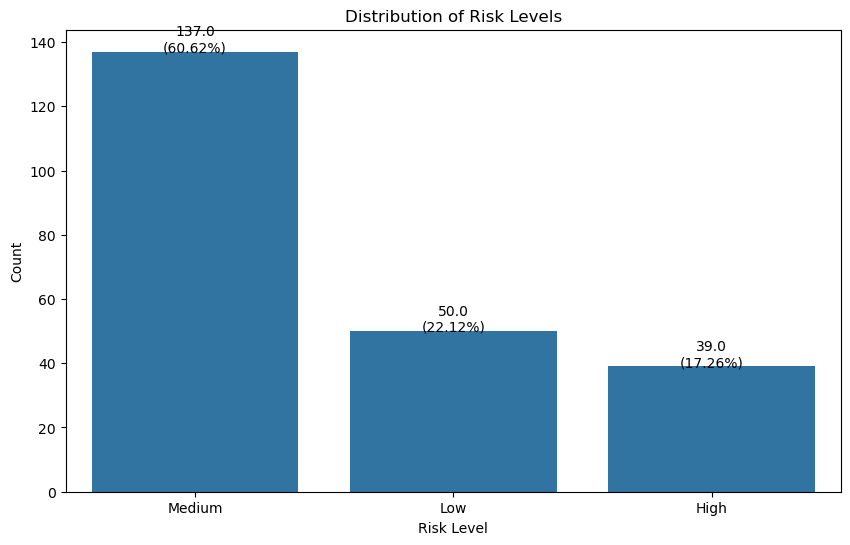

In [38]:
# Plot the count of stocks for each risk level
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=filtered_stocks, x='Risk_Level', order=filtered_stocks['Risk_Level'].value_counts().index)
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')

# Add counts and percentages above bars
for p in ax.patches:
    count = p.get_height()
    total = len(filtered_stocks)
    percentage = (count / total) * 100
    ax.annotate(f'{count}\n({percentage:.2f}%)', (p.get_x() + p.get_width() / 2., count),
                ha='center', va='baseline', fontsize=10)

plt.show()

#### Save the Filtered Data to a CSV file

In [39]:
# Save the filtered DataFrame to a new CSV file
filtered_stocks.to_csv('snp_portfolio_risk_rsi+macd_filtered.csv', index=False)

#### Read the CSV file

In [40]:
# Read the filtered DataFrame from the CSV file
filtered_stocks = pd.read_csv('snp_portfolio_risk_rsi+macd_filtered.csv')
filtered_stocks.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,ABT,Low,Medical Devices,0.751,0.254548,37.664,33.514020,-0.071,-1.618899,-1.661040,...,105.900002,105.269997,107.279999,107.070000,107.589996,106.889999,106.860001,107.529999,107.269997,105.970001
1,AEE,Low,Utilities - Regulated Electric,0.443,0.216294,148.496,16.300459,-0.011,0.582307,0.485202,...,71.930000,72.510002,73.879997,74.379997,74.019997,74.709999,74.760002,73.660004,74.349998,73.870003
2,AEP,Low,Utilities - Regulated Electric,0.500,0.208181,170.989,16.443203,1.527,0.820753,0.492052,...,80.450737,81.757919,83.381981,84.075188,84.728767,85.530907,86.016144,84.431686,85.827988,85.194206
3,AJG,Low,Insurance Brokers,0.694,0.252346,75.987,51.530487,0.251,-2.659436,-2.695624,...,230.520004,233.990005,236.570007,237.520004,237.869995,236.809998,236.949997,234.110001,233.550003,234.690002
4,ATO,Low,Utilities - Regulated Gas,0.656,0.230794,64.859,17.312216,0.208,0.677511,0.414041,...,114.559998,114.570000,117.199997,118.080002,117.669998,118.660004,118.169998,116.930000,118.639999,117.900002


## Integrate News Sentiment Analysis

In [41]:
!pip install textblob
!pip install newsapi-python


  Using cached textblob-0.18.0.post0-py3-none-any.whl.metadata (4.5 kB)
Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)
  Using cached newsapi_python-0.2.7-py2.py3-none-any.whl.metadata (1.2 kB)
Using cached newsapi_python-0.2.7-py2.py3-none-any.whl (7.9 kB)


In [54]:
import requests
from textblob import TextBlob
from newsapi import NewsApiClient

# Function to get news for a given stock symbol
def get_news(stock_symbol):
    try:
        newsapi = NewsApiClient(api_key='<your_api_key_here>')
        all_articles = newsapi.get_everything(q=stock_symbol, language='en', sort_by='relevancy', page_size=10)
        if all_articles['status'] == 'ok':
            titles = [article['title'] for article in all_articles['articles']]
            return titles
        else:
            print(f"Error fetching news for {stock_symbol}: {all_articles['message']}")
            return []
    except Exception as e:
        print(f"Exception occurred while fetching news for {stock_symbol}: {e}")
        return []

# Function to perform sentiment analysis and make recommendations
def make_recommendations(titles):
    recommendations = []
    for title in titles:
        analysis = TextBlob(title)
        sentiment = 'positive' if analysis.sentiment.polarity >= 0 else 'negative'
        recommendations.append((title, sentiment))
    return recommendations

# Function to filter stocks based on sentiment analysis
def filter_stocks_based_on_sentiment(stock_symbols):
    filtered_stocks = []
    for stock_symbol in stock_symbols:
        titles = get_news(stock_symbol)
        if titles:
            recommendations = make_recommendations(titles)
            negative_count = sum(1 for rec in recommendations if rec[1] == 'negative')
            total_count = len(recommendations)
            negative_percentage = (negative_count / total_count) * 100
            
            if negative_percentage <= 70:
                filtered_stocks.append(stock_symbol)
                print(f"Stock {stock_symbol} passed with {negative_percentage:.2f}% negative news.")
            else:
                print(f"Stock {stock_symbol} failed with {negative_percentage:.2f}% negative news.")
        else:
            filtered_stocks.append(stock_symbol)
            print(f"No titles retrieved or error occurred for {stock_symbol}.")
    
    return filtered_stocks

In [43]:
# # Call function
# stock_symbols = {"AAPL", "GOOGL", "MSFT"}
# filtered_stocks = filter_stocks_based_on_sentiment(stock_symbols)
# print(f"Filtered stocks: {filtered_stocks}")


In [55]:
# Read the filtered stock data from news_sentiment_filtered_stocks

# Empty df
sentiment_filtered_stocks = pd.DataFrame()

# First check if the file exists
import os
if os.path.exists('news_sentiment_filtered_stocks.csv'):
    print("File exists")
    # Read the filtered DataFrame from the CSV file
    sentiment_filtered_stocks = pd.read_csv('news_sentiment_filtered_stocks.csv')
    sentiment_filtered_stocks.head()
else:
    print("File does not exist")
    sentiment_filtered_stocks.head()


File does not exist


#### Check News Sentiment for High Risk Stocks

In [56]:
# Call High Risk stocks
stock_symbols_high = set(filtered_high_risk_stocks['Stock'])
print(f"All stocks: {stock_symbols_high}")
len(stock_symbols_high)


All stocks: {'ON', 'AAL', 'ABNB', 'PARA', 'VTR', 'SWKS', 'UAL', 'MHK', 'BBWI', 'TSLA', 'KLAC', 'TECH', 'QRVO', 'BLDR', 'RCL', 'PHM', 'COF', 'HWM', 'NVDA', 'ADBE', 'AMD', 'ULTA', 'DFS', 'URI', 'EXPE', 'MS', 'MCHP', 'CCL', 'DAY', 'MRNA', 'NCLH', 'LULU', 'TPR', 'AAPL', 'DAL', 'ILMN', 'MPWR', 'TRMB', 'ETSY'}


39

In [57]:
# Call News Sentiment Function
sentiment_filtered_stocks_high = filter_stocks_based_on_sentiment(stock_symbols_high)
print(f"Filtered High Risk stocks: {sentiment_filtered_stocks_high}")
len(sentiment_filtered_stocks_high)

Stock ON passed with 10.00% negative news.
Stock AAL passed with 0.00% negative news.
Stock ABNB passed with 0.00% negative news.
Stock PARA passed with 0.00% negative news.
Stock VTR passed with 10.00% negative news.
Stock SWKS passed with 0.00% negative news.
Stock UAL passed with 10.00% negative news.
Stock MHK passed with 0.00% negative news.
Stock BBWI passed with 10.00% negative news.
Stock TSLA passed with 10.00% negative news.
Stock KLAC passed with 0.00% negative news.
Stock TECH passed with 10.00% negative news.
Stock QRVO passed with 10.00% negative news.
Stock BLDR passed with 0.00% negative news.
Stock RCL passed with 10.00% negative news.
Stock PHM passed with 10.00% negative news.
Stock COF passed with 10.00% negative news.
Stock HWM passed with 10.00% negative news.
Stock NVDA passed with 0.00% negative news.
Stock ADBE passed with 0.00% negative news.
Stock AMD passed with 0.00% negative news.
Stock ULTA passed with 20.00% negative news.
Stock DFS passed with 0.00% neg

39

In [62]:
print(filtered_high_risk_stocks.shape)
# Save the filtered stocks to dataframe with following columns: Stock, Risk_Level, and LastUpdated
filtered_high_risk_stocks = filtered_high_risk_stocks[filtered_high_risk_stocks['Stock'].isin(sentiment_filtered_stocks_high)]
filtered_high_risk_stocks['LastUpdated'] = pd.Timestamp.now()
filtered_high_risk_stocks['Risk_Level'] = 'High'

print(filtered_high_risk_stocks.head())
print(filtered_high_risk_stocks.shape)

(39, 2532)
   Stock Risk_Level                   Industry   Beta  Volatility  \
1     ON       High                   Airlines  1.580    0.658142   
2    AAL       High       Consumer Electronics  1.264    0.443116   
4   ABNB       High            Travel Services  1.246    0.508553   
8   PARA       High  Software - Infrastructure  1.281    0.485039   
27   VTR       High             Semiconductors  1.660    0.592271   

    Debt_to_Equity    PE_Ratio  Earnings_Growth       MACD     Signal  ...  \
1       172.635933   16.197184         0.468858  -0.129848  -0.153215  ...   
2       140.968000   30.572980        -0.022000  -0.861375  -1.433049  ...   
4        29.002000   19.659517         1.256000   0.133508   0.029556  ...   
8        26.429000   44.453674        -0.503000 -12.908131 -14.923782  ...   
27        5.335000  243.289860         0.468858  -6.084851  -6.849901  ...   

    2024-04-18 00:00:00  2024-04-19 00:00:00  2024-04-22 00:00:00  \
1             14.020000            1

In [63]:
# Now check if the sentiment_filtered_stocks df - if it is not empty, then append the filtered_high_risk_stocks to it
if sentiment_filtered_stocks.empty:
    sentiment_filtered_stocks = filtered_high_risk_stocks[['Stock', 'Risk_Level', 'LastUpdated', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap (Millions)', 'Dividend_Yield']]
else:
    sentiment_filtered_stocks = pd.concat([sentiment_filtered_stocks, filtered_high_risk_stocks[['Stock', 'Risk_Level', 'LastUpdated', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap (Millions)', 'Dividend_Yield']]])

sentiment_filtered_stocks.head()

,Stock,Risk_Level,LastUpdated,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,EPS,Market_Cap (Millions),Dividend_Yield
1,ON,High,2024-06-09 09:32:19.507737,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,39.044930,0.71,7.545035e+03,0.023981
2,AAL,High,2024-06-09 09:32:19.507737,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,52.048345,6.44,3.019131e+06,0.005100
4,ABNB,High,2024-06-09 09:32:19.507737,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,43.219668,7.46,9.310623e+04,0.023981
8,PARA,High,2024-06-09 09:32:19.507737,Software - Infrastructure,1.281,0.485039,26.429000,44.453674,-0.503000,-12.908131,-14.923782,31.481773,10.47,2.085126e+05,0.023981
27,VTR,High,2024-06-09 09:32:19.507737,Semiconductors,1.660,0.592271,5.335000,243.289860,0.468858,-6.084851,-6.849901,49.252898,0.69,2.713300e+05,0.023981


In [64]:
# Save the updated DataFrame to a new CSV file
sentiment_filtered_stocks.to_csv('news_sentiment_filtered_stocks.csv', index=False)

In [65]:
# Read
sentiment_filtered_stocks = pd.read_csv('news_sentiment_filtered_stocks.csv')
sentiment_filtered_stocks.head()

,Stock,Risk_Level,LastUpdated,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,EPS,Market_Cap (Millions),Dividend_Yield
0,ON,High,2024-06-09 09:32:19.507737,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,39.044930,0.71,7.545035e+03,0.023981
1,AAL,High,2024-06-09 09:32:19.507737,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,52.048345,6.44,3.019131e+06,0.005100
2,ABNB,High,2024-06-09 09:32:19.507737,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,43.219668,7.46,9.310623e+04,0.023981
3,PARA,High,2024-06-09 09:32:19.507737,Software - Infrastructure,1.281,0.485039,26.429000,44.453674,-0.503000,-12.908131,-14.923782,31.481773,10.47,2.085126e+05,0.023981
4,VTR,High,2024-06-09 09:32:19.507737,Semiconductors,1.660,0.592271,5.335000,243.289860,0.468858,-6.084851,-6.849901,49.252898,0.69,2.713300e+05,0.023981


#### Check News Sentiment for Low Risk Stocks

In [66]:
# Call Low Risk stocks
stock_symbols_low = set(filtered_low_risk_stocks['Stock'])
print(f"All Low stocks: {stock_symbols_low}")
print(len(stock_symbols_low))

# Call News Sentiment Function
sentiment_filtered_stocks_low = filter_stocks_based_on_sentiment(stock_symbols_low)
print(f"Filtered Low Risk stocks: {sentiment_filtered_stocks_low}")
print(len(sentiment_filtered_stocks_low))

print(filtered_low_risk_stocks.shape)
# Save the filtered stocks to dataframe with following columns: Stock, Risk_Level, and LastUpdated
filtered_low_risk_stocks = filtered_low_risk_stocks[filtered_low_risk_stocks['Stock'].isin(sentiment_filtered_stocks_low)]
filtered_low_risk_stocks['LastUpdated'] = pd.Timestamp.now()
filtered_low_risk_stocks['Risk_Level'] = 'Low'

print(filtered_low_risk_stocks.head())
print(filtered_low_risk_stocks.shape)

# Now check if the sentiment_filtered_stocks df - if it is not empty, then append the filtered_low_risk_stocks to it
if sentiment_filtered_stocks.empty:
    sentiment_filtered_stocks = filtered_low_risk_stocks[['Stock', 'Risk_Level', 'LastUpdated', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap (Millions)', 'Dividend_Yield']]
else:
    sentiment_filtered_stocks = pd.concat([sentiment_filtered_stocks, filtered_low_risk_stocks[['Stock', 'Risk_Level', 'LastUpdated', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap (Millions)', 'Dividend_Yield']]])

sentiment_filtered_stocks.head()

All Low stocks: {'EXC', 'ES', 'EVRG', 'UDR', 'GIS', 'NI', 'T', 'WEC', 'HII', 'MRK', 'PNW', 'RSG', 'SRE', 'CLX', 'CMS', 'NEE', 'SJM', 'WBA', 'ROL', 'ETR', 'SO', 'HRL', 'MKC', 'JNJ', 'MCD', 'VRSK', 'CPB', 'ATO', 'HSY', 'MTB', 'AJG', 'XEL', 'DUK', 'PEP', 'LLY', 'ED', 'K', 'LNT', 'EG', 'ABT', 'AEE', 'DTE', 'CAG', 'AWK', 'PM', 'D', 'AEP', 'MAA', 'CBOE', 'FE'}
50
Stock EXC passed with 0.00% negative news.
Stock ES passed with 10.00% negative news.
Stock EVRG passed with 0.00% negative news.
Stock UDR passed with 10.00% negative news.
Stock GIS passed with 0.00% negative news.
Stock NI passed with 20.00% negative news.
Stock T passed with 0.00% negative news.
Stock WEC passed with 0.00% negative news.
Stock HII passed with 0.00% negative news.
Stock MRK passed with 0.00% negative news.
Stock PNW passed with 10.00% negative news.
Stock RSG passed with 0.00% negative news.
Stock SRE passed with 10.00% negative news.
Stock CLX passed with 0.00% negative news.
Stock CMS passed with 30.00% negativ

,Stock,Risk_Level,LastUpdated,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,EPS,Market_Cap (Millions),Dividend_Yield
0,ON,High,2024-06-09 09:32:19.507737,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,39.044930,0.71,7.545035e+03,0.023981
1,AAL,High,2024-06-09 09:32:19.507737,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,52.048345,6.44,3.019131e+06,0.005100
2,ABNB,High,2024-06-09 09:32:19.507737,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,43.219668,7.46,9.310623e+04,0.023981
3,PARA,High,2024-06-09 09:32:19.507737,Software - Infrastructure,1.281,0.485039,26.429000,44.453674,-0.503000,-12.908131,-14.923782,31.481773,10.47,2.085126e+05,0.023981
4,VTR,High,2024-06-09 09:32:19.507737,Semiconductors,1.660,0.592271,5.335000,243.289860,0.468858,-6.084851,-6.849901,49.252898,0.69,2.713300e+05,0.023981


In [67]:
# Save the updated DataFrame to a new CSV file
sentiment_filtered_stocks.to_csv('news_sentiment_filtered_stocks.csv', index=False)

# Read
sentiment_filtered_stocks = pd.read_csv('news_sentiment_filtered_stocks.csv')
sentiment_filtered_stocks.head()

,Stock,Risk_Level,LastUpdated,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,EPS,Market_Cap (Millions),Dividend_Yield
0,ON,High,2024-06-09 09:32:19.507737,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,39.044930,0.71,7.545035e+03,0.023981
1,AAL,High,2024-06-09 09:32:19.507737,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,52.048345,6.44,3.019131e+06,0.005100
2,ABNB,High,2024-06-09 09:32:19.507737,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,43.219668,7.46,9.310623e+04,0.023981
3,PARA,High,2024-06-09 09:32:19.507737,Software - Infrastructure,1.281,0.485039,26.429000,44.453674,-0.503000,-12.908131,-14.923782,31.481773,10.47,2.085126e+05,0.023981
4,VTR,High,2024-06-09 09:32:19.507737,Semiconductors,1.660,0.592271,5.335000,243.289860,0.468858,-6.084851,-6.849901,49.252898,0.69,2.713300e+05,0.023981


In [68]:
sentiment_filtered_stocks.shape

(89, 15)

#### Check News Sentiment for Medium Risk Stocks

In [69]:
# Call Medium Risk stocks
stock_symbols_medium = set(filtered_medium_risk_stocks['Stock'])
print(f"All Medium stocks: {stock_symbols_medium}")
print(len(stock_symbols_medium))

# Call News Sentiment Function
sentiment_filtered_stocks_medium = filter_stocks_based_on_sentiment(stock_symbols_medium)
print(f"Filtered Medium Risk stocks: {sentiment_filtered_stocks_medium}")
print(len(sentiment_filtered_stocks_medium))

print(filtered_medium_risk_stocks.shape)
# Save the filtered stocks to dataframe with following columns: Stock, Risk_Level, and LastUpdated
filtered_medium_risk_stocks = filtered_medium_risk_stocks[filtered_medium_risk_stocks['Stock'].isin(sentiment_filtered_stocks_medium)]
filtered_medium_risk_stocks['LastUpdated'] = pd.Timestamp.now()
filtered_medium_risk_stocks['Risk_Level'] = 'Low'

print(filtered_medium_risk_stocks.head())
print(filtered_medium_risk_stocks.shape)

# Now check if the sentiment_filtered_stocks df - if it is not empty, then append the filtered_low_risk_stocks to it
if sentiment_filtered_stocks.empty:
    sentiment_filtered_stocks = filtered_medium_risk_stocks[['Stock', 'Risk_Level', 'LastUpdated', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap (Millions)', 'Dividend_Yield']]
else:
    sentiment_filtered_stocks = pd.concat([sentiment_filtered_stocks, filtered_medium_risk_stocks[['Stock', 'Risk_Level', 'LastUpdated', 'Industry', 'Beta', 'Volatility', 'Debt_to_Equity', 'PE_Ratio', 'Earnings_Growth', 'MACD', 'Signal', 'RSI', 'EPS', 'Market_Cap (Millions)', 'Dividend_Yield']]])

sentiment_filtered_stocks.head()

All Medium stocks: {'AMCR', 'FRT', 'CB', 'INTU', 'CPT', 'AXON', 'ALB', 'C', 'SYY', 'ZTS', 'L', 'EA', 'BF-B', 'DOV', 'CF', 'PPL', 'SYF', 'CSGP', 'NEM', 'GEV', 'DOC', 'UHS', 'TXN', 'WM', 'HSIC', 'VST', 'CHRW', 'GS', 'KIM', 'HPQ', 'AVGO', 'INVH', 'PCG', 'EQR', 'DHR', 'COR', 'AVB', 'UNP', 'O', 'VLTO', 'AXP', 'LMT', 'EQT', 'TDG', 'BA', 'PODD', 'AIZ', 'UPS', 'WFC', 'MDT', 'CDW', 'CVX', 'FI', 'LW', 'SOLV', 'CHTR', 'CNC', 'VTRS', 'GPC', 'HES', 'CNP', 'HD', 'GL', 'ELV', 'DGX', 'DRI', 'OMC', 'AMT', 'APTV', 'VRTX', 'YUM', 'LH', 'DECK', 'BAC', 'RHI', 'AIG', 'IPG', 'BLK', 'LHX', 'SBUX', 'XYL', 'DLR', 'FOX', 'GOOG', 'RL', 'TFC', 'EIX', 'ESS', 'KMI', 'MNST', 'WAT', 'VICI', 'CFG', 'AFL', 'IR', 'MCK', 'JPM', 'UNH', 'OKE', 'COST', 'AVY', 'SYK', 'GM', 'ADI', 'IRM', 'SNPS', 'GPN', 'EL', 'TMO', 'GOOGL', 'APD', 'REG', 'BXP', 'NKE', 'CCI', 'BK', 'IQV', 'AKAM', 'INCY', 'STX', 'SPGI', 'PWR', 'TJX', 'TFX', 'HAS', 'STE', 'BSX', 'FDS', 'GE', 'PNC', 'FMC', 'FITB', 'PANW', 'IDXX', 'RVTY', 'TSN', 'AMGN'}
137
Stock A

,Stock,Risk_Level,LastUpdated,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,RSI,EPS,Market_Cap (Millions),Dividend_Yield
0,ON,High,2024-06-09 09:32:19.507737,Airlines,1.580,0.658142,172.635933,16.197184,0.468858,-0.129848,-0.153215,39.044930,0.71,7.545035e+03,0.023981
1,AAL,High,2024-06-09 09:32:19.507737,Consumer Electronics,1.264,0.443116,140.968000,30.572980,-0.022000,-0.861375,-1.433049,52.048345,6.44,3.019131e+06,0.005100
2,ABNB,High,2024-06-09 09:32:19.507737,Travel Services,1.246,0.508553,29.002000,19.659517,1.256000,0.133508,0.029556,43.219668,7.46,9.310623e+04,0.023981
3,PARA,High,2024-06-09 09:32:19.507737,Software - Infrastructure,1.281,0.485039,26.429000,44.453674,-0.503000,-12.908131,-14.923782,31.481773,10.47,2.085126e+05,0.023981
4,VTR,High,2024-06-09 09:32:19.507737,Semiconductors,1.660,0.592271,5.335000,243.289860,0.468858,-6.084851,-6.849901,49.252898,0.69,2.713300e+05,0.023981


In [70]:
sentiment_filtered_stocks.shape

(226, 15)

In [71]:
# Save the updated DataFrame to a new CSV file
sentiment_filtered_stocks.to_csv('news_sentiment_filtered_stocks.csv', index=False)

# Read
sentiment_filtered_stocks = pd.read_csv('news_sentiment_filtered_stocks.csv')
print(sentiment_filtered_stocks.head())

sentiment_filtered_stocks.shape

  Stock Risk_Level                 LastUpdated                   Industry  \
0    ON       High  2024-06-09 09:32:19.507737                   Airlines   
1   AAL       High  2024-06-09 09:32:19.507737       Consumer Electronics   
2  ABNB       High  2024-06-09 09:32:19.507737            Travel Services   
3  PARA       High  2024-06-09 09:32:19.507737  Software - Infrastructure   
4   VTR       High  2024-06-09 09:32:19.507737             Semiconductors   

    Beta  Volatility  Debt_to_Equity    PE_Ratio  Earnings_Growth       MACD  \
0  1.580    0.658142      172.635933   16.197184         0.468858  -0.129848   
1  1.264    0.443116      140.968000   30.572980        -0.022000  -0.861375   
2  1.246    0.508553       29.002000   19.659517         1.256000   0.133508   
3  1.281    0.485039       26.429000   44.453674        -0.503000 -12.908131   
4  1.660    0.592271        5.335000  243.289860         0.468858  -6.084851   

      Signal        RSI    EPS  Market_Cap (Millions)  D

(226, 15)

In [ ]:
# # Create a function that will check the oldest lastUpdated date for each risk level and call the news sentiment function for those stocks whose lastUpdated date is older than 3 days, and return the existing sentiment_filtered_stocks df for other risk levels
# # Function to filter stocks based on lastUpdated date
# def filter_stocks_based_on_lastUpdated(risk_level):
#     df = pd.read_csv('news_sentiment_filtered_stocks.csv')
#     print(df.head())
#     # Get the oldest lastUpdated date for the given risk level
#     oldest_date = df[df['Risk_Level'] == risk_level]['LastUpdated'].min()
#     # Check if the date is older than 3 days
#     if pd.Timestamp.now() - oldest_date > pd.Timedelta(days=3):
#         # Get the stock symbols for the given risk level
#         stock_symbols = set(df[df['Risk_Level'] == risk_level]['Stock'])
#         # Call the news sentiment function
#         filtered_stocks = filter_stocks_based_on_sentiment(stock_symbols)
#         # Filter the DataFrame based on the filtered stocks
#         filtered_df = df[df['Stock'].isin(filtered_stocks)]
#         # Update the lastUpdated date
#         filtered_df['LastUpdated'] = pd.Timestamp.now()
#         return filtered_df
#     else:
#         return df[df['Risk_Level'] == risk_level]

# Final Portofolio Creation Based on VaR (Value at Risk)

In [74]:
filtered_stocks = pd.read_csv('snp_portfolio_risk_rsi+macd_filtered.csv')
filtered_stocks.head()

,Stock,Risk_Level,Industry,Beta,Volatility,Debt_to_Equity,PE_Ratio,Earnings_Growth,MACD,Signal,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00,2024-04-29 00:00:00,2024-04-30 00:00:00
0,ABT,Low,Medical Devices,0.751,0.254548,37.664,33.514020,-0.071,-1.618899,-1.661040,...,105.900002,105.269997,107.279999,107.070000,107.589996,106.889999,106.860001,107.529999,107.269997,105.970001
1,AEE,Low,Utilities - Regulated Electric,0.443,0.216294,148.496,16.300459,-0.011,0.582307,0.485202,...,71.930000,72.510002,73.879997,74.379997,74.019997,74.709999,74.760002,73.660004,74.349998,73.870003
2,AEP,Low,Utilities - Regulated Electric,0.500,0.208181,170.989,16.443203,1.527,0.820753,0.492052,...,80.450737,81.757919,83.381981,84.075188,84.728767,85.530907,86.016144,84.431686,85.827988,85.194206
3,AJG,Low,Insurance Brokers,0.694,0.252346,75.987,51.530487,0.251,-2.659436,-2.695624,...,230.520004,233.990005,236.570007,237.520004,237.869995,236.809998,236.949997,234.110001,233.550003,234.690002
4,ATO,Low,Utilities - Regulated Gas,0.656,0.230794,64.859,17.312216,0.208,0.677511,0.414041,...,114.559998,114.570000,117.199997,118.080002,117.669998,118.660004,118.169998,116.930000,118.639999,117.900002


In [75]:
filtered_stocks['Risk_Level'].value_counts()

Risk_Level
Medium    137
Low        50
High       39
Name: count, dtype: int64

In [76]:
filtered_stocks.shape

(226, 2531)

In [77]:
# Ensure required columns are numeric
filtered_stocks['Beta'] = pd.to_numeric(filtered_stocks['Beta'], errors='coerce')
filtered_stocks['Volatility'] = pd.to_numeric(filtered_stocks['Volatility'], errors='coerce')
filtered_stocks['Debt_to_Equity'] = pd.to_numeric(filtered_stocks['Debt_to_Equity'], errors='coerce')
filtered_stocks['PE_Ratio'] = pd.to_numeric(filtered_stocks['PE_Ratio'], errors='coerce')
filtered_stocks['Earnings_Growth'] = pd.to_numeric(filtered_stocks['Earnings_Growth'], errors='coerce')
filtered_stocks['EPS'] = pd.to_numeric(filtered_stocks['EPS'], errors='coerce')
filtered_stocks['Market_Cap (Millions)'] = pd.to_numeric(filtered_stocks['Market_Cap (Millions)'], errors='coerce')
filtered_stocks['Dividend_Yield'] = pd.to_numeric(filtered_stocks['Dividend_Yield'], errors='coerce')
filtered_stocks['MACD'] = pd.to_numeric(filtered_stocks['MACD'], errors='coerce')
filtered_stocks['Signal'] = pd.to_numeric(filtered_stocks['Signal'], errors='coerce')
filtered_stocks['RSI'] = pd.to_numeric(filtered_stocks['RSI'], errors='coerce')

In [78]:
# VaR
import itertools

In [79]:
# Function to calculate daily returns
def calculate_daily_returns(df):
    numeric_columns = df.apply(pd.to_numeric, errors='coerce').select_dtypes(include=[np.number])
    print(f"Numeric columns for returns calculation: {numeric_columns.columns.tolist()}")
    daily_returns = numeric_columns.pct_change().dropna()
    print(f"Daily returns calculated, shape: {daily_returns.shape}")
    return daily_returns


In [80]:
# Function to calculate Value at Risk (VaR)
def calculate_var(returns, confidence_level=0.95):
    if len(returns) == 0:
        return np.nan
    sorted_returns = np.sort(returns)
    index = int((1 - confidence_level) * len(sorted_returns))
    var = sorted_returns[index]
    return var

In [81]:
import pandas as pd
import numpy as np
import random

In [82]:
# Function to get the best portfolio based on VaR
def get_best_portfolio(df, risk_level, num_stocks, sample_size=1000):
    # Filter stocks for particular risk level
    print(f"Filtering stocks for risk level: {risk_level}")
    filtered_df = filter_stocks(df, risk_level)
    
    if filtered_df.empty:
        print("No stocks found after filtering.")
        return None, np.inf
    
    # COMMENTED OUT: Uncomment once news sentiment code is working
    # Now filter stocks based on news sentiment
    # stock_symbols = filtered_df['Stock'].values
    # filtered_stocks = filter_stocks_based_on_sentiment(stock_symbols)
    # filtered_df = filtered_df[filtered_df['Stock'].isin(filtered_stocks)]
    # Reading already sentiment filtered stocks 
    #TODO: Use the dynamic function that checks if the lastUpdated date is older than 3 days and then makes call to the sentiment function
    sentiment_filtered_stocks = pd.read_csv('news_sentiment_filtered_stocks.csv')
    # Only keep stocks from the filtered_df in the sentiment_filtered_stocks
    filtered_df = filtered_df[filtered_df['Stock'].isin(sentiment_filtered_stocks['Stock'])]
    print(f"Filtered stocks based on news sentiment: {filtered_df.shape}")

    # Calculate daily returns
    stock_list = filtered_df['Stock'].values
    daily_prices = df.loc[df['Stock'].isin(stock_list)].set_index('Stock').iloc[:, 13:]

    if daily_prices.empty:
        print("No price data available for the filtered stocks.")
        return None, np.inf

    try:
        daily_returns = calculate_daily_returns(daily_prices.T)
        daily_returns = daily_returns.T.reset_index()
        print(f"Daily returns calculated, shape: {daily_returns.shape}")
    except Exception as e:
        print(f"Error calculating daily returns: {e}")
        return None, np.inf

    best_var = np.inf
    best_portfolio = None

    # Randomly sample combinations
    if len(stock_list) < num_stocks:
        print("Not enough stocks to form a portfolio.")
        return None, np.inf
    
    combinations_checked = 0
    for combination in itertools.combinations(stock_list, num_stocks):
        combinations_checked += 1
        if combinations_checked > sample_size:
            break
        selected_stocks = list(combination)
        try:
            if set(selected_stocks).issubset(daily_returns['Stock']):
                portfolio_returns = daily_returns.set_index('Stock').loc[selected_stocks].mean()
                var = calculate_var(portfolio_returns.values)
                if var < best_var:
                    best_var = var
                    best_portfolio = selected_stocks
            else:
                print(f"Skipping combination {selected_stocks} as they are not in daily returns columns.")
        except Exception as e:
            print(f"Error with combination {selected_stocks}: {e}")

    print(f"Total combinations checked: {combinations_checked}")
    return best_portfolio, best_var


#### Medium Risk Level

In [83]:
portfolio_medium = get_best_portfolio(filtered_stocks, risk_level='Medium', num_stocks=10)
print("Recommended Medium Risk Portfolio:", portfolio_medium)

Filtering stocks for risk level: Medium
Filtered stocks based on news sentiment: (137, 2531)
Numeric columns for returns calculation: ['ADI', 'AFL', 'AIG', 'AIZ', 'AKAM', 'ALB', 'AMCR', 'AMGN', 'AMT', 'APD', 'APTV', 'AVB', 'AVGO', 'AVY', 'AXON', 'AXP', 'BA', 'BAC', 'BF-B', 'BK', 'BLK', 'BSX', 'BXP', 'C', 'CB', 'CCI', 'CDW', 'CF', 'CFG', 'CHRW', 'CHTR', 'CNC', 'CNP', 'COR', 'COST', 'CPT', 'CSGP', 'CVX', 'DECK', 'DGX', 'DHR', 'DLR', 'DOC', 'DOV', 'DRI', 'EA', 'EIX', 'EL', 'ELV', 'EQR', 'EQT', 'ESS', 'FDS', 'FI', 'FITB', 'FMC', 'FOX', 'FRT', 'GE', 'GEV', 'GL', 'GM', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GS', 'HAS', 'HD', 'HES', 'HPQ', 'HSIC', 'IDXX', 'INCY', 'INTU', 'INVH', 'IPG', 'IQV', 'IR', 'IRM', 'JPM', 'KIM', 'KMI', 'L', 'LH', 'LHX', 'LMT', 'LW', 'MCK', 'MDT', 'MNST', 'NEM', 'NKE', 'O', 'OKE', 'OMC', 'PANW', 'PCG', 'PNC', 'PODD', 'PPL', 'PWR', 'REG', 'RHI', 'RL', 'RVTY', 'SBUX', 'SNPS', 'SOLV', 'SPGI', 'STE', 'STX', 'SYF', 'SYK', 'SYY', 'TDG', 'TFC', 'TFX', 'TJX', 'TMO', 'TSN', 'TXN', 'UHS

#### High Risk Level

In [85]:
portfolio_high = get_best_portfolio(filtered_stocks, risk_level='High', num_stocks=10)
print("Recommended High Risk Portfolio:", portfolio_high)

Filtering stocks for risk level: High
Filtered stocks based on news sentiment: (39, 2531)
Numeric columns for returns calculation: ['AAL', 'AAPL', 'ABNB', 'ADBE', 'AMD', 'BBWI', 'BLDR', 'CCL', 'COF', 'DAL', 'DAY', 'DFS', 'ETSY', 'EXPE', 'HWM', 'ILMN', 'KLAC', 'LULU', 'MCHP', 'MHK', 'MPWR', 'MRNA', 'MS', 'NCLH', 'NVDA', 'ON', 'PARA', 'PHM', 'QRVO', 'RCL', 'SWKS', 'TECH', 'TPR', 'TRMB', 'TSLA', 'UAL', 'ULTA', 'URI', 'VTR']
Daily returns calculated, shape: (850, 39)
Daily returns calculated, shape: (39, 851)
Total combinations checked: 1001
Recommended High Risk Portfolio: (['AAL', 'AAPL', 'ABNB', 'ADBE', 'AMD', 'BBWI', 'BLDR', 'CCL', 'NCLH', 'TSLA'], -0.03545860163516208)


#### Low Risk Level

In [86]:
portfolio_low = get_best_portfolio(filtered_stocks, risk_level='Low', num_stocks=10)
print("Recommended Low Risk Portfolio:", portfolio_low)

Filtering stocks for risk level: Low
Filtered stocks based on news sentiment: (50, 2531)
Numeric columns for returns calculation: ['ABT', 'AEE', 'AEP', 'AJG', 'ATO', 'AWK', 'CAG', 'CBOE', 'CLX', 'CMS', 'CPB', 'D', 'DTE', 'DUK', 'ED', 'EG', 'ES', 'ETR', 'EVRG', 'EXC', 'FE', 'GIS', 'HII', 'HRL', 'HSY', 'JNJ', 'K', 'LLY', 'LNT', 'MAA', 'MCD', 'MKC', 'MRK', 'MTB', 'NEE', 'NI', 'PEP', 'PM', 'PNW', 'ROL', 'RSG', 'SJM', 'SO', 'SRE', 'T', 'UDR', 'VRSK', 'WBA', 'WEC', 'XEL']
Daily returns calculated, shape: (2516, 50)
Daily returns calculated, shape: (50, 2517)
Total combinations checked: 1001
Recommended Low Risk Portfolio: (['ABT', 'AEE', 'AEP', 'AJG', 'ATO', 'AWK', 'CAG', 'CBOE', 'ES', 'FE'], -0.01542534817079837)
